## STEP 4: DEVELOP A FUZZY LOGIC MODEL

A fuzzy logic model is one that is built on expert knowledge rather than
training data. You may wish to use the
[`scikit-fuzzy`](https://pythonhosted.org/scikit-fuzzy/) library, which
includes many utilities for building this sort of model. In particular,
it contains a number of **membership functions** which can convert your
data into values from 0 to 1 using information such as, for example, the
maximum, minimum, and optimal values for soil pH.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>To train a fuzzy logic habitat suitability model:</p>
<pre><code>1. Research S. nutans, and find out what optimal values are for each variable you are using (e.g. soil pH, slope, and current climatological annual precipitation). 
2. For each **digital number** in each raster, assign a **continuous** value from 0 to 1 for how close that grid square is to the optimum range (1=optimal, 0=incompatible). 
3. Combine your layers by multiplying them together. This will give you a single suitability number for each square.
4. Optionally, you may apply a suitability threshold to make the most suitable areas pop on your map.</code></pre></div></div>

> **Tip**
>
> If you use mathematical operators on a raster in Python, it will
> automatically perform the operation for every number in the raster.
> This type of operation is known as a **vectorized** function. **DO NOT
> DO THIS WITH A LOOP!**. A vectorized function that operates on the
> whole array at once will be much easier and faster.

<span style='color: purple'>

Optimal and tolerable ranges:

* Soil:
    * Optimal pH: 6.5
    * Tolerable range: 5.0 - 7.5
    * *Source:* https://www.fs.usda.gov/psw/publications/documents/psw_rp028/psw_rp028.pdf

* Elevation:
    * Optimal: 100 ft - 2,500 ft
    * Tolerable range: sealevel - 3,000 ft
    * *Source for both ranges:* https://www.fs.usda.gov/psw/publications/documents/psw_rp028/psw_rp028.pdf

* Average annual precipitation:
    * Optimal: 50 in - 70 in (1270 mm - 1800 mm)
        * It was difficult to find a description of an exact optimal range of precipitation for the coastal redwood, so I am using the mean precipitation values from two different sources. The 50 inch number is from [here](https://www.nps.gov/parkhistory/online_books/shirley/sec4.htm#:~:text=The%20main%20part%20of%20the,100%20inches%20of%20rainfall%20annually.) and the 70 inch number is from [here](https://www.fs.usda.gov/database/feis/plants/tree/seqsem/all.html#11). 
    * Tolerable range: [20 in - 200 in (508 mm - 5080 mm)](https://plants.usda.gov/plant-profile/SESE3/characteristics)
</span>

<span style='color: purple'>

Load in stored variables:

</span>

In [1]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf
%store -r siskiyou_soil_ph_da padres_soil_ph_da
%store -r siskiyou_srtm_da padres_srtm_da
%store -r ave_annual_pr_das_list climate_df_list
%store -r siskiyou_elev_reproj_da padres_elev_reproj_da reproj_ave_annual_pr_das

<span style='color: purple'>

Import packages:

</span>

In [21]:
from math import floor, ceil

import cartopy.crs as ccrs
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import numpy as np
import rioxarray as rxr
import rioxarray.merge as rxrmerg
import skfuzzy as fuzz # Create fuzzy logic model
import xarray as xr

<span style='color:purple'>

## First look at suitability using boolean logic:

</span>

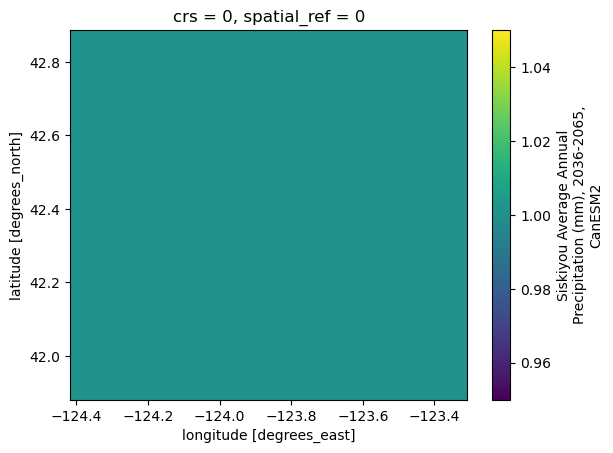

In [6]:
(reproj_ave_annual_pr_das[0] < 5080).plot()

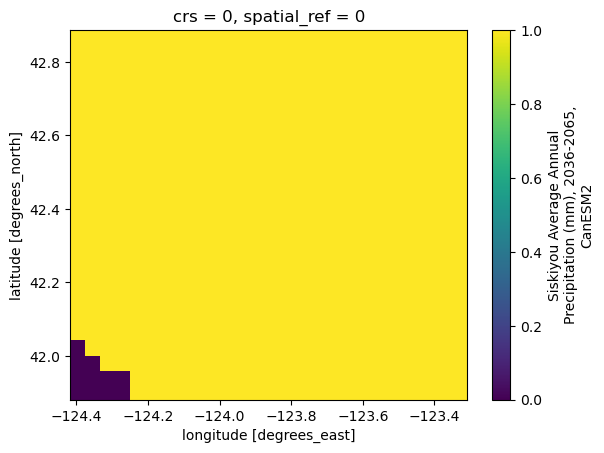

In [7]:
(reproj_ave_annual_pr_das[0] > 508).plot()

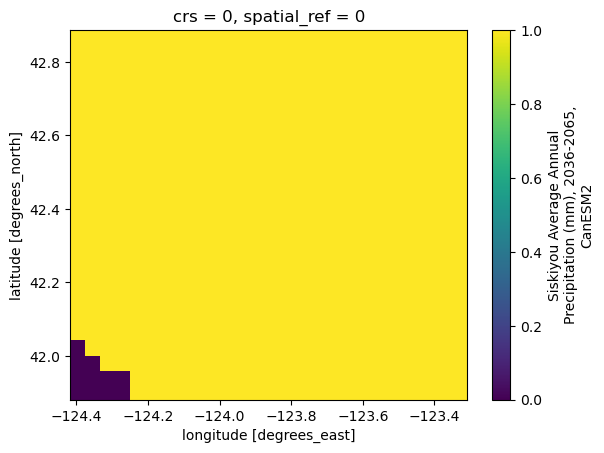

In [16]:
# use 'bitwise and' to see suitability of min and max precip values together
precip_suit = ((reproj_ave_annual_pr_das[0] > 508) & (reproj_ave_annual_pr_das[0] < 5080))
precip_suit.plot()

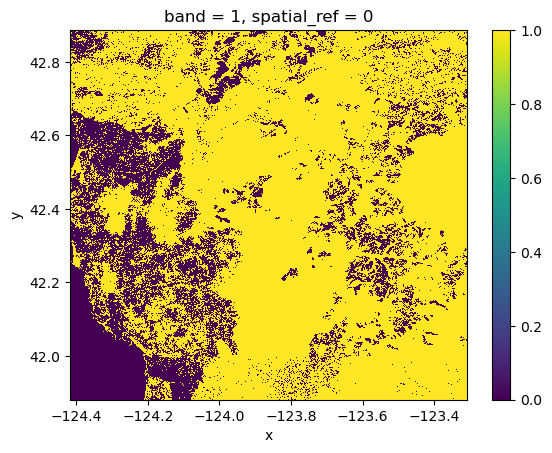

In [17]:
(siskiyou_soil_ph_da > 5.0).plot()

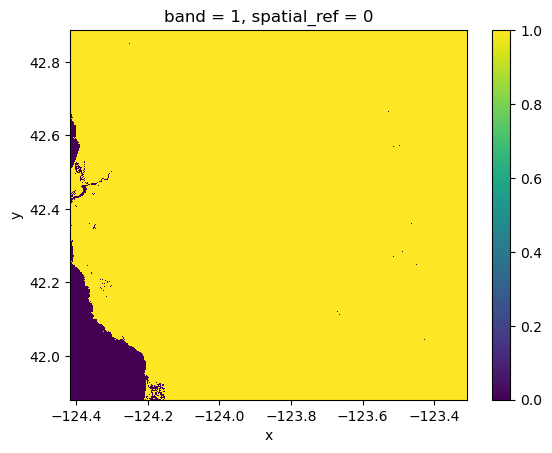

In [18]:
(siskiyou_soil_ph_da < 7.5).plot()

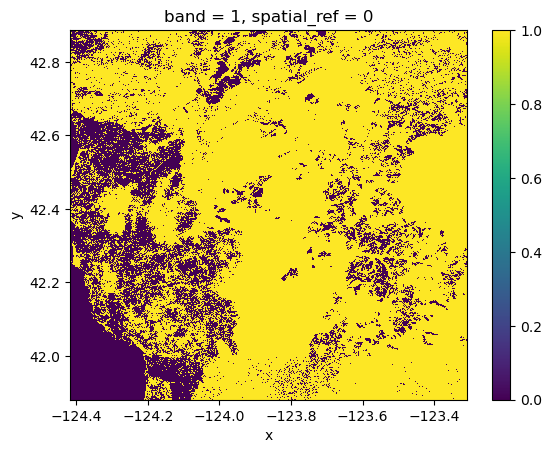

In [19]:
# use 'bitwise and' to see suitability of min and max pH values together
ph_suit = ((siskiyou_soil_ph_da > 5.0) & (siskiyou_soil_ph_da < 7.5))
ph_suit.plot()

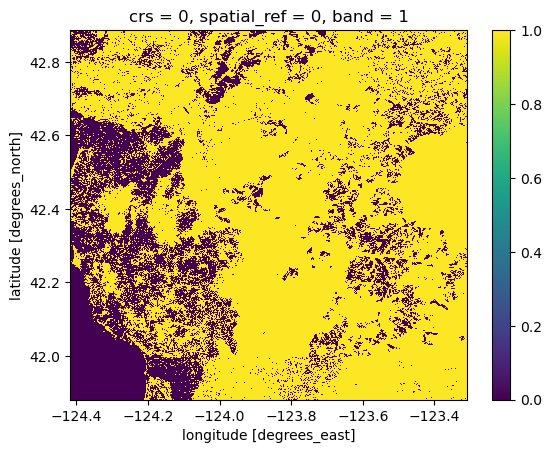

In [20]:
# find suitability of precipitation and ph together
# this multiplies together each value of each suitability plot together
(precip_suit * ph_suit).plot()

<span style='color:purple'>

## Now look at suitability using fuzzy logic:

Going to use the trapezoidal membership function so that our optimal values have a range and or tolerable values have a range

</span>

In [ ]:
# get details of trapmf function
help(fuzz.trapmf)

Help on function trapmf in module skfuzzy.membership.generatemf:

trapmf(x, abcd)
    Trapezoidal membership function generator.
    
    Parameters
    ----------
    x : 1d array
        Independent variable.
    abcd : 1d array, length 4
        Four-element vector.  Ensure a <= b <= c <= d.
    
    Returns
    -------
    y : 1d array
        Trapezoidal membership function.



None of the values in the siskiyou_soil_ph_da are exactly 6.5, and I know that redwoods currently live in siskiyou, so instead of using a triangular membership function w/ one optimum value, we'll use a trapezoidal membership function and a range around 6.5.

MemoryError: Unable to allocate 13.8 MiB for an array with shape (3622, 3989) and data type bool

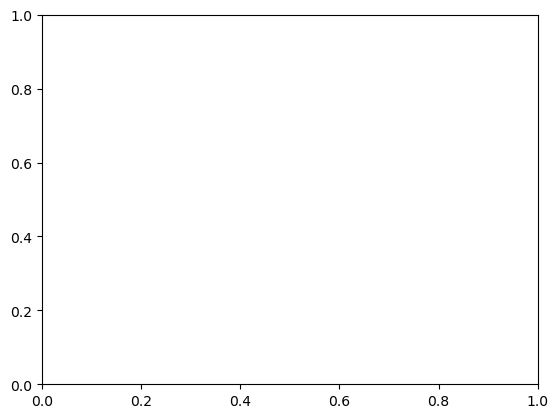

In [28]:
# save shape of siskiyou_soil_ph_da
shape = (siskiyou_soil_ph_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy siskiyou_soil_ph_da to keep all coordinates, etc
siskiyou_ph_fuzz = siskiyou_soil_ph_da.copy()

# create membership function
siskiyou_ph_fuzz.values = (
    # reshape 1D array created below back to siskiyou_soil_ph_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            siskiyou_soil_ph_da.values.flatten(),
            # pH tolerance and optimum values
            [5.0, 6.0, 7.0, 7.5]),
            shape
            )
        )
siskiyou_ph_fuzz.plot()